# Telco Customer Churn Prediction 📞📉

This notebook presents an end-to-end machine learning pipeline to predict customer churn using a telecom dataset. The goal is to identify customers likely to discontinue their service.

We perform:
- Data cleaning and preprocessing
- Feature encoding and scaling
- Model training using hyperparameter optimization (Optuna)
- Stacking ensemble modeling
- Performance evaluation using precision, recall, F1-score, and ROC-AUC

In [1]:
import pandas as pd
import numpy as np
import random
import os
import warnings

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

# Load dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Drop irrelevant or problematic columns
df.drop(columns=['customerID', 'TotalCharges', 'gender', 'PhoneService'], inplace=True, errors='ignore')

df.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes


## Data Preprocessing

We separate features from the target, split the data, and define preprocessing steps including:
- Ordinal encoding for ordered categorical variables
- One-hot encoding for nominal variables
- Standard scaling for numerical features


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# Prepare features and target
X = df.drop(['Churn'], axis=1)  # Dropping gender and PhoneService
y = LabelEncoder().fit_transform(df['Churn'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Update column lists after dropping 'gender' and 'PhoneService'
binary_cols = ['Partner', 'Dependents', 'PaperlessBilling']  # Removed 'gender' and 'PhoneService'
ordinal_service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
ordinal_phone_col = ['MultipleLines']
ordinal_contract_col = ['Contract']
nominal_cols = ['PaymentMethod', 'InternetService']

# Update corresponding mappings
binary_mapping = [
    ['No', 'Yes'],          # Partner
    ['No', 'Yes'],          # Dependents
    ['No', 'Yes']           # PaperlessBilling
]
service_mapping = [['No internet service', 'No', 'Yes']] * 6
phone_mapping = [['No phone service', 'No', 'Yes']]
contract_mapping = [['Month-to-month', 'One year', 'Two year']]

# Combine features and mappings
ordinal_features = binary_cols + ordinal_service_cols + ordinal_phone_col + ordinal_contract_col
ordinal_categories = binary_mapping + service_mapping + phone_mapping + contract_mapping

# Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('ord', OrdinalEncoder(categories=ordinal_categories), ordinal_features),
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), nominal_cols)
], remainder='passthrough')

In [3]:
from sklearn.preprocessing import StandardScaler

X_train_enc_arr = preprocessor.fit_transform(X_train)
X_test_enc_arr = preprocessor.transform(X_test)

ordinal_names = ordinal_features
ohe_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(nominal_cols).tolist()
passthrough_cols = [col for col in X_train.columns if col not in ordinal_features + nominal_cols]
final_col_names = ordinal_names + ohe_names + passthrough_cols

X_train = pd.DataFrame(X_train_enc_arr, columns=final_col_names, index=X_train.index)
X_test = pd.DataFrame(X_test_enc_arr, columns=final_col_names, index=X_test.index)

numeric_cols = ['tenure', 'MonthlyCharges']
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


## Model Training with Hyperparameter Tuning

We use Optuna to tune five base classifiers:
- K-Nearest Neighbors (KNN)
- Support Vector Classifier (SVC)
- Random Forest
- Logistic Regression
- XGBoost

Each model is evaluated using cross-validated F1 score with oversampling to address class imbalance.


In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

def crossval_score(model):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    ros = RandomOverSampler(random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]
        X_res, y_res = ros.fit_resample(X_tr, y_tr)
        model.fit(X_res, y_res)
        y_pred = model.predict(X_val)
        scores.append(f1_score(y_val, y_pred))
    return np.mean(scores)

In [5]:
def objective_knn(trial):
    model = KNeighborsClassifier(
        n_neighbors=trial.suggest_int('n_neighbors', 10, 50),
        weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
        p=trial.suggest_int('p', 1, 2)
    )
    return crossval_score(model)

def objective_svc(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 1e-4, 10, log=True)
    gamma = trial.suggest_float('gamma', 1e-4, 1.0, log=True)
    degree = trial.suggest_int('degree', 2, 4) if kernel == 'poly' else 3
    model = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree)
    return crossval_score(model)

def objective_rf(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000, step=100),
        max_depth=trial.suggest_int('max_depth', 2, 20),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 10, 100, step=10),
        criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
        random_state=42, n_jobs=-1)
    return crossval_score(model)

def objective_lr(trial):
    C = trial.suggest_float('C', 1e-4, 100, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])
    if penalty == 'l1' and solver == 'lbfgs':
        raise optuna.exceptions.TrialPruned()
    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=1000, random_state=42, n_jobs=-1)
    return crossval_score(model)

def objective_xgb(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 1000, step=100),
        max_depth=trial.suggest_int('max_depth', 3, 12),
        learning_rate=trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        gamma=trial.suggest_float('gamma', 1e-4, 5.0, log=True),
        reg_alpha=trial.suggest_float('reg_alpha', 1e-4, 5.0, log=True),
        reg_lambda=trial.suggest_float('reg_lambda', 1e-4, 5.0, log=True),
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1
    )
    return crossval_score(model)

In [6]:
from tqdm.notebook import tqdm
import time

optuna.logging.set_verbosity(optuna.logging.WARNING)

studies = {
    'knn': (objective_knn, KNeighborsClassifier),
    'svc': (objective_svc, SVC),
    'rf': (objective_rf, RandomForestClassifier),
    'lr': (objective_lr, LogisticRegression),
    'xgb': (objective_xgb, XGBClassifier)
}

models = {}

# Create outer progress bar for models
for name, (obj_fn, model_class) in tqdm(studies.items(), desc="🔧 Model Tuning", total=len(studies)):
    print(f"\n📌 Tuning model: {name.upper()}")
    start = time.time()

    study = optuna.create_study(direction='maximize')
    
    # Add inner progress bar
    with tqdm(total=30, desc=f"🔍 {name.upper()} Trials") as trial_bar:
        def callback(study, trial):
            trial_bar.update(1)

        study.optimize(obj_fn, n_trials=30, callbacks=[callback])
    
    duration = time.time() - start
    best_params = study.best_params
    
    # Special handling for XGBoost
    if name == 'xgb':
        best_params['eval_metric'] = 'logloss'
    
    print(f"✅ Finished {name.upper()} - Best F1: {study.best_value:.4f} - Time: {duration:.1f}s")
    # Special handling for SVC
    if name == 'svc':
        best_params['probability'] = True

    # Special handling for SVC
    if name == 'lr':
        best_params['max_iter'] = 2000

    # Train final model with best params
    model = model_class(**best_params)
    X_res, y_res = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    model.fit(X_res, y_res)
    
    models[name] = model


🔧 Model Tuning:   0%|          | 0/5 [00:00<?, ?it/s]


📌 Tuning model: KNN


🔍 KNN Trials:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Finished KNN - Best F1: 0.6119 - Time: 11.0s

📌 Tuning model: SVC


🔍 SVC Trials:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Finished SVC - Best F1: 0.6262 - Time: 167.7s

📌 Tuning model: RF


🔍 RF Trials:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Finished RF - Best F1: 0.6325 - Time: 92.9s

📌 Tuning model: LR


🔍 LR Trials:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Finished LR - Best F1: 0.6288 - Time: 27.1s

📌 Tuning model: XGB


🔍 XGB Trials:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Finished XGB - Best F1: 0.6357 - Time: 91.6s


## Stacking Ensemble

We combine the predictions of all tuned models using a Logistic Regression meta-classifier with passthrough features for final prediction.

In [7]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', models['xgb']),
        ('knn', models['knn']),
        ('svc', models['svc']),
        ('rf', models['rf']),
        ('lr', models['lr']),
    ],
    final_estimator = LogisticRegression(max_iter=5000),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

X_train_stack, y_train_stack = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
stacking_clf.fit(X_train_stack, y_train_stack)


StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7978065129804022,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None,
                                              gamma=4.640366096821334,
                                              grow_policy=None,
                                              i...
                               ('knn', KNeighborsClassifier(n_neighbors=30)),
                               ('svc',
                                SVC(C=0.0013301578393958013,
                                    gamma=0.43927366425720404, kernel='poly',
                                    probability=True)),
                               ('rf',
                                RandomForestClassifier(max_depth=7,
                                                       max_leaf_nodes=100,
                                                       n_estimators=200)),
                               ('lr',
                                LogisticRegression(C=0.31393011559193906,
                                                   max_iter=2000, penalty='l1',
                                                   solver='saga'))],
                   final_estimator=LogisticRegression(max_iter=5000), n_jobs=-1,
                   passthrough=True)

## Model Evaluation

We evaluate the stacked model using:
- ROC-AUC
- F1-score at optimal threshold
- Precision-Recall curve
- Confusion Matrix


In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_proba = stacking_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]
y_pred = (y_proba >= best_threshold).astype(int)

print("Classification Report at Optimal Threshold:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0     0.9037    0.7614    0.8264      1035
           1     0.5400    0.7754    0.6367       374

    accuracy                         0.7651      1409
   macro avg     0.7219    0.7684    0.7315      1409
weighted avg     0.8071    0.7651    0.7761      1409



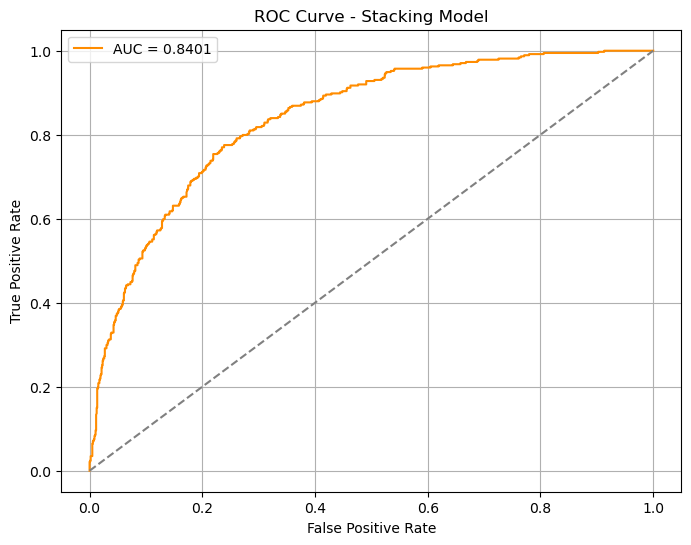

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Model")
plt.legend()
plt.grid(True)
plt.show()


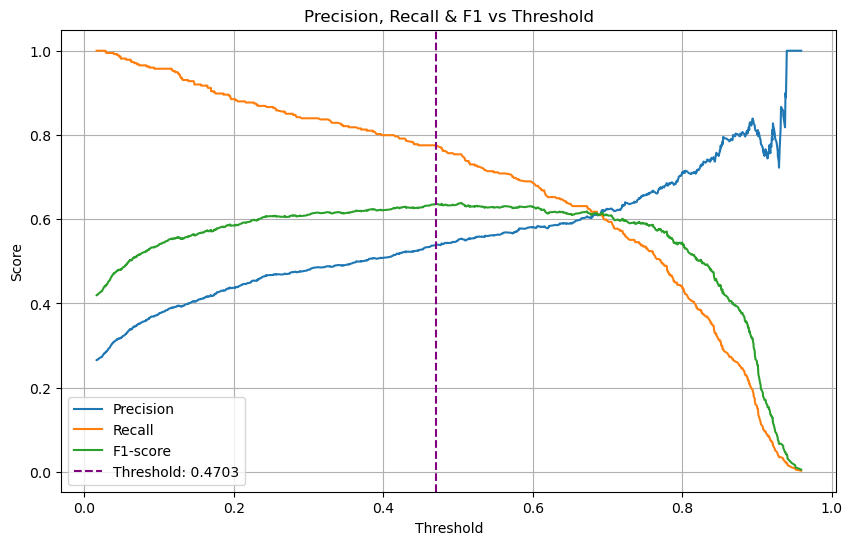

In [10]:
prec, rec, thresh = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)

plt.figure(figsize=(10, 6))
plt.plot(thresh, prec[:-1], label='Precision')
plt.plot(thresh, rec[:-1], label='Recall')
plt.plot(thresh, f1[:-1], label='F1-score')
plt.axvline(best_threshold, linestyle='--', color='purple', label=f'Threshold: {best_threshold:.4f}')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall & F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

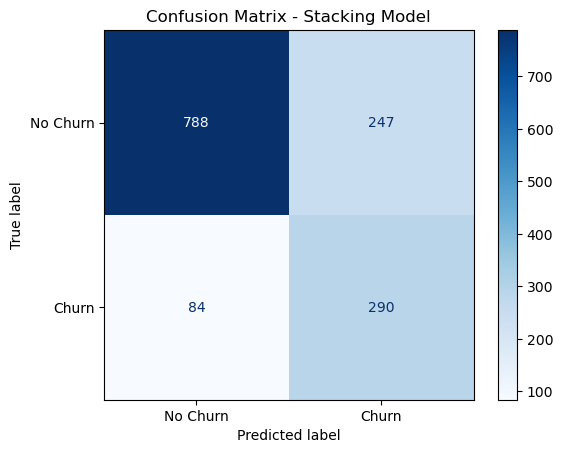

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Stacking Model")
plt.grid(False)
plt.show()